In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos import cbl
from algos.supervised import SupervisedEngine

from common.models import resnet, deeplab
from common import metrics
from common.models.modutils import load_model


# Hyperparameters

In [ ]:
log_dir = "./final/cbl"

horizon = 1024
stride = 512

batch_size_con = 8
batch_size_sup = 16

num_epochs_con = 10
num_epochs_sup = 5

learning_rate_con = 5e-3
learning_rate_sup = 1e-3

weight_decay_con = 1e-1
weight_decay_sup = 1e-2

supervised_percentage = 0.25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Contrastive

## Datasets

In [ ]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [ ]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


In [ ]:
train_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size_con,
    shuffle=True,
)
test_loader = DataLoader(
    data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride),
    batch_size_con,
    shuffle=False,
)


## Model

In [ ]:
backbone = resnet.ResNetFeatures(
    resnet.Bottleneck,
    resnet.RESNET50_LAYERS,
    num_features=data.NUM_FEATURES,
    return_layers=[resnet.LAYER_1, resnet.LAYER_4],
    replace_stride_with_dilation=[False, True, True],
    norm_layer=torch.nn.InstanceNorm1d
)
optim = AdamW(backbone.parameters(), lr=learning_rate_con, weight_decay=weight_decay_con)
lr_sched = CosineAnnealingLR(optim, num_epochs_con)

engine_contrastive = cbl.CBLFeatsEngine(
    model=backbone,
    optimizer=optim,
    temperature=0.5,
    aug_1=cbl.left_to_right_flipping(),
    aug_2=cbl.crop_and_resize(),
    lr_scheduler=lr_sched,
    device=device,
)


## Training

In [ ]:
with SummaryWriter(log_dir + "/contrastive/logs") as writer:
    training_loop(
        engine=engine_contrastive,
        num_epochs=num_epochs_con,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/contrastive/models",
    )


Epoch 0 - train_loss = 1.741 - test_loss = 2.279 - lr = 1.00e-03


Epoch 1 - train_loss = 1.665 - test_loss = 2.299 - lr = 9.76e-04


Epoch 2 - train_loss = 1.538 - test_loss = 2.281 - lr = 9.05e-04


Epoch 3 - train_loss = 1.597 - test_loss = 2.273 - lr = 7.94e-04


Epoch 4 - train_loss = 1.460 - test_loss = 2.249 - lr = 6.55e-04


Epoch 5 - train_loss = 1.325 - test_loss = 2.244 - lr = 5.00e-04


Epoch 6 - train_loss = 1.508 - test_loss = 2.254 - lr = 3.45e-04


Epoch 7 - train_loss = 1.384 - test_loss = 2.247 - lr = 2.06e-04


Epoch 8 - train_loss = 1.353 - test_loss = 2.254 - lr = 9.55e-05


Epoch 9 - train_loss = 1.319 - test_loss = 2.242 - lr = 2.45e-05


# Supervised

## Dataset

In [ ]:
n_samples = int(len(test) * supervised_percentage)
m_data_train.data = m_data_train.data[:n_samples]

sup_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size_sup,
    shuffle=True,
)


## Model

In [ ]:
for p in backbone.parameters():
    p.requires_grad = False

model = deeplab.DeepLabNet(backbone, backbone_channels=[256, 2048], out_feats=1)

optim = AdamW(
    model.head.parameters(), lr=learning_rate_sup, weight_decay=weight_decay_sup
)
lr_sched = CosineAnnealingLR(optim, num_epochs_sup)
engine_supervised = SupervisedEngine(
    model, device, optimizer=optim, lr_scheduler=lr_sched
)


## Training

In [ ]:
with SummaryWriter(log_dir + "/supervised/logs") as writer:
    training_loop(
        engine=engine_supervised,
        num_epochs=num_epochs_sup,
        train_dataloader=sup_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/supervised/models",
    )


Test 0:   1%|          | 1/81 [00:00<00:11,  6.71it/s]  f:\Users\Zumo\Documents\Github\AI_Industry_Project\notebooks\common\metrics.py:56: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[0]


Epoch 0 - train_loss = 0.309 - test_loss = 0.266 - test_cost=945.926 - test_threshold=-1.448 - lr = 1.00e-03


Epoch 1 - train_loss = 0.192 - test_loss = 0.159 - test_cost=721.420 - test_threshold=-1.905 - lr = 9.05e-04


Epoch 2 - train_loss = 0.140 - test_loss = 0.155 - test_cost=671.136 - test_threshold=-2.126 - lr = 6.55e-04


Epoch 3 - train_loss = 0.170 - test_loss = 0.154 - test_cost=670.333 - test_threshold=-2.276 - lr = 3.45e-04


Epoch 4 - train_loss = 0.139 - test_loss = 0.154 - test_cost=658.284 - test_threshold=-2.423 - lr = 9.55e-05


# Evaluating

In [ ]:
load_model(model, log_dir + "/models/model_4.pth", device);

In [ ]:
# Cost model
cmodel = metrics.default_cmodel()


In [ ]:
scores, labels = get_predictions(engine_supervised.predict, test_loader)


100%|██████████| 81/81 [00:08<00:00,  9.23it/s]


In [ ]:
cmodel.fit(scores, labels).optimize()


(-2.0099854373931834, 167.9011)

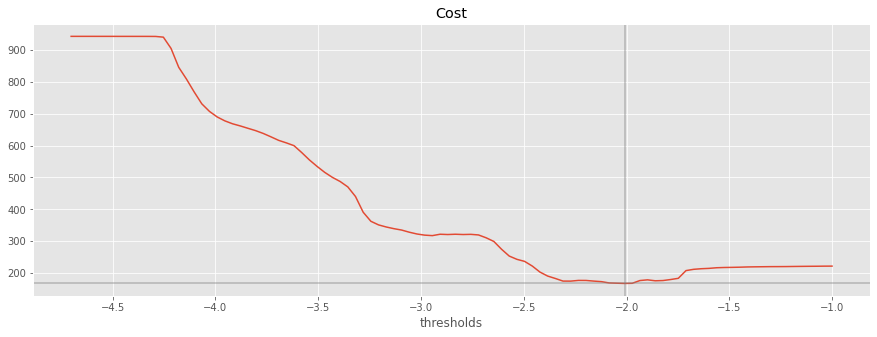

In [ ]:
metrics.plot_cost(cmodel)


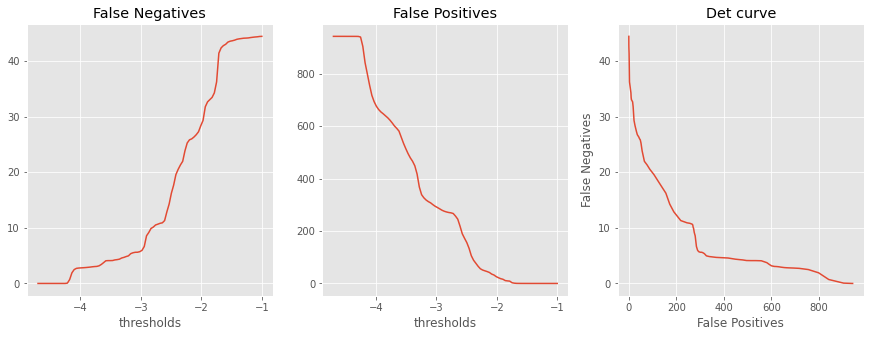

In [ ]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


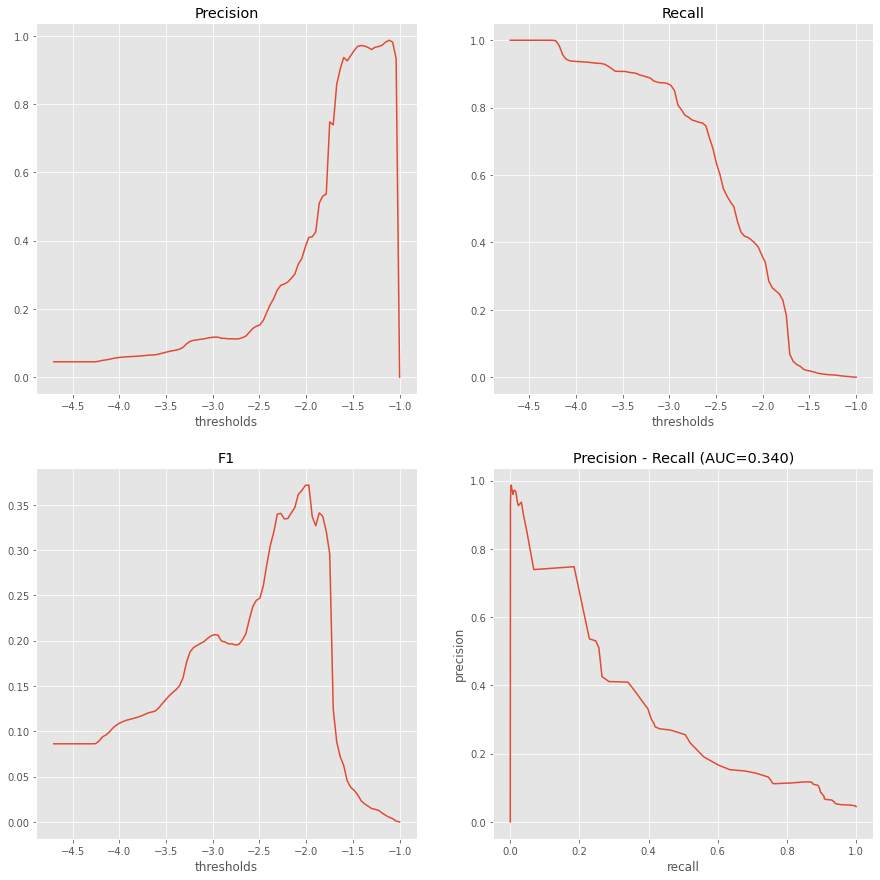

In [ ]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)